# Introduction to Word Embeddings

Open in [Google Colab](https://colab.research.google.com/github/febse/ta2025/blob/main/03-01-Word-Embeddings-Overview.ipynb)


Until now our approach to representing words has been treating them as discrete symbols. Each word was represented as a one-hot vector, i.e., a vector of length V (the size of the vocabulary) with a 1 in the position corresponding to the word and 0s elsewhere. 

For a document with the vocabulary consisting of the words "cat", "dog", "fish", the word "dog" would be represented as the vector [0, 1, 0], the word "cat" as [1, 0, 0], and the word "fish" as [0, 0, 1].

**This representation has several limitations:**


- The length of the vector is equal to the size of the vocabulary, which can be very large (tens or hundreds of thousands of words).
- This representation cannot capture any relationships between the words (all vectors are orthogonal to each other) and hence cannot capture semantic or syntactic similarities between words.

As a solution to the first problem we can use dense vector representations of words, i.e., vectors of much smaller size (e.g., 100 or 300 dimensions) where each dimension can take any real value. Such dense vector representations are called **word embeddings**. We actually already saw one method that in effect compressed the sparse one-hot vectors into dense vectors when we applied SVD to the term-document matrix in Latent Semantic Analysis (LSA).

However, these word embeddings are unlikely to capture semantic relationships between words if they are learned in isolation.

The word2vec model [@MIKOLOV2013EfficientEstimationWord] turned out to deliver impressive results by learning word embeddings based on the context in which words appear. There are two variants of the word2vec model: Continuous Bag of Words (CBOW) and Skip-gram.

The skip-gram model tries to predict the context words given a target word. The architecture of the skip-gram model is shown in the figure below.

For example in a sentence "The cat sits on the mat", if the target word is "sits", the context words could be "The", "cat", "on", "the", "mat". The model takes the one-hot vector of the target word as input, passes it through a hidden layer (which is essentially a weight matrix that transforms the one-hot vector into a dense vector), and then tries to predict the one-hot vectors of the context words.

![Skip-gram Model](./figures/skip-gram-architecture.webp)

To make sense of this architecture, let's consider some simpler models that will help us understand how the skip-gram model works.

## Linear Regression as a Neural Network



In [108]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from IPython import display

In [109]:
n = 100
p = 1

X = np.random.randn(n, p)
e = np.random.randn(n)
beta = np.array([2])
y = 2 + X @ beta + e
y = (y - np.mean(y)) / np.std(y)

In [110]:
linreg = LinearRegression()
linreg.fit(X, y)

print("Intercept:", linreg.intercept_)
print("Coefficient:", linreg.coef_)


Intercept: 0.073421823861589
Coefficient: [0.96430093]


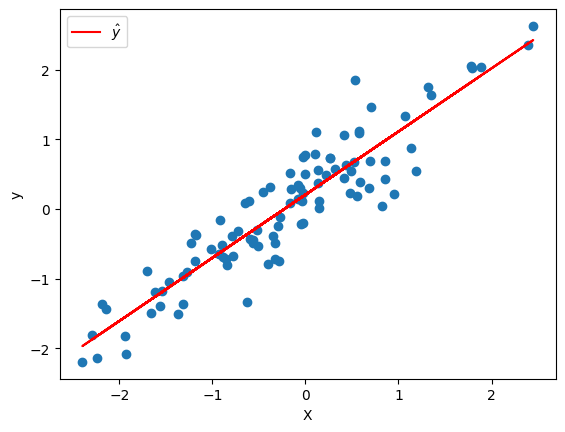

In [101]:
# Plot the predicted values

plt.scatter(X, y)
plt.plot(X, linreg.predict(X), color='red', label = r'$\hat{y}$')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

## Simple Linear Regression as a ANN

With one predictor variable the simple linear model predicts an outcome variable as a linear function of the predictor variable:

$$
\hat{y}_i = \hat{\beta}_0 + \beta_1 x_{i}
$$

Where the coefficients are chosen to minimize the mean squared error loss function.

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

A linear regression model is a special case of a neural network with no hidden layers, a linear activation function, and a mean squared error loss function. The usual neural network notation uses $w$ for the weights and $b$ for the biases instead of $\beta$ for the coefficients. The equation for the ANN model is:

$$
\hat{y}_i = b + w_1 x_{i1} + \ldots + w_p x_{ip} = b + w^T x_i
$$

which is simply the dot product of the weights and the inputs plus the bias term.
The usual visualization of this model is a single neuron with $p$ inputs and a single output. The neuron computes the weighted sum of the inputs plus a bias term. The output of the neuron passes through the identity activation function and produces the predicted value $\hat{y}$.

In the simplest case we have one input (feature) and one output (target variable):

$$
\hat{y}_i = \mathbb{I}(b + w x_i)
$$

![Linear Regression as a Neural Network](./figures/ann/Linear-Regression-Single-Input-Single-Output.png)

{{ video ./videos/SingleNeuronComputation.mp4 }}

So if we know the values of the weight and the bias, we can compute the predicted value for any input by simply multiplying the input by the weight and adding the bias. How do we find sensible values for the weight and the bias?


## Gradient Descent for Simple Linear Regression

We can use gradient descent to find the optimal values of the weights and the bias that minimize the loss function. The loss function for linear regression is the mean squared error (MSE) which for a single observation (sample) is:

$$
L_i = (\text{actual} - \text{predicted})^2 = (y_i - \hat{y}_i)^2
$$

The gradient descent algorithm iteratively updates the weights and the bias in the direction of the negative gradient of the loss function with respect to the weights and the bias.

$$
\begin{align*}
w_1^{\text{new}} = w_1^{\text{old}} - \eta \frac{\partial L_i}{\partial w_1} \\
b^{\text{new}} = b^{\text{old}} - \eta \frac{\partial L_i}{\partial b}
\end{align*}
$$

where $\eta$ is the learning rate, a hyperparameter that controls the step size of the updates. To actually perform the updates, we need to compute the gradients of the loss function with respect to the weights and the bias. This is quite straightforward here:


$$
\begin{align*}
\frac{\partial L_i}{\partial w_1} & = \frac{\partial }{\partial w_1} (y_i - \hat{y}_i)^2 \\
                                  & = (y_i - \hat{y}_i) \frac{\partial }{\partial w_1} \hat{y}_i \\
                                  & = -2 (y_i - \hat{y}_i) x_{i}
\end{align*}
$$

$$
\begin{align*}
\frac{\partial L_i}{\partial b} & = \frac{\partial }{\partial b} (y_i - \hat{y}_i)^2 \\
                                  & = (y_i - \hat{y}_i) \frac{\partial }{\partial b} \hat{y}_i \\
                                  & = -2 (y_i - \hat{y}_i)
\end{align*}
$$

/tmp/ipykernel_149961/1275960156.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses[epoch] = epoch_loss / n


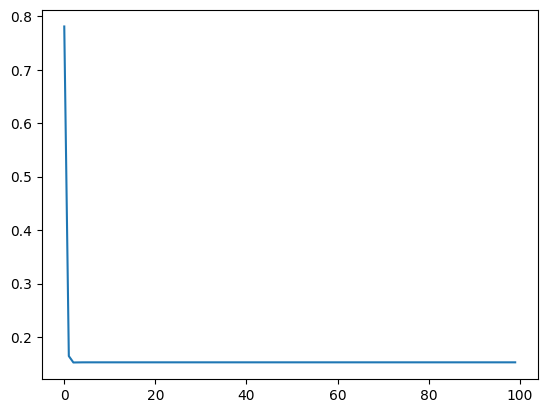

In [104]:
epochsn = 100
lr = 0.01

w = np.random.randn(p)
b = np.random.randn(1)

losses = np.zeros(epochsn)

for epoch in range(epochsn):
    epoch_loss = 0

    for i in range(n):
        y_pred = w.dot(X[i]) + b
        
        loss = (y[i] - y_pred) ** 2

        # Update the weight
        gradient_w = -2 * X[i].T * (y[i] - y_pred)
        w = w - lr * gradient_w

        # Update the bias
        gradient_b = -2 * (y[i] - y_pred)
        b = b - lr * gradient_b
        epoch_loss += loss

    losses[epoch] = epoch_loss / n

plt.plot(losses)


In [107]:
print("The coefficient of the linear regression model:", linreg.coef_)
print("The weight after training", w)

The coefficient of the linear regression model: [0.90613256]
The weight after training [0.90934603]


## A Neural Network as a Function Approximator

Neural networks become more interesting when we add hidden layers and non-linear activation function.

https://www.desmos.com/calculator/jwruoptwuv

https://www.desmos.com/calculator/gmsdth4fmf

{{ video ./videos/SingleInputHiddenLayer.mp4 }}

For a network with one one input and two neurons in the hidden layer, one output and ReLU activation function, the equation for the output is:

$$
\hat{y} = w_{h1} \cdot \text{ReLU}(h_1) + w_{h2} \cdot \text{ReLU}(h_2) + b_o
$$

The hidden layer neurons compute their activations as:

$$
\begin{align*}
h_1 & = w_{1} \cdot x + b_{1} \\
h_2 & = w_{2} \cdot x + b_{2}
\end{align*}
$$

So the final equation for the output is:

$$
\hat{y} = w_{h1} \cdot \text{ReLU}(w_{1} \cdot x + b_{1}) + w_{h2} \cdot \text{ReLU}(w_{2} \cdot x + b_{2}) + b_o
$$
